In [1]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw

#Making the directory where boards will be saved


In [2]:
# Run this command only once:

# makes the output folder /content/boards/
!mkdir boards

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Board Generator

In [4]:
#!/usr/bin/env python3

import cv2
import csv
import numpy as np
import os
import random
from PIL import Image, ImageFont, ImageDraw

entries = {'SIZE': [''.join(random.choices(string.ascii_uppercase + string.digits + ' ', k=12)) for _ in range(20)],
           'VICTIM': [''.join(random.choices(string.ascii_uppercase + string.digits+ ' ', k=12)) for _ in range(20)],
           'CRIME': [''.join(random.choices(string.ascii_uppercase + string.digits+ ' ', k=12)) for _ in range(20)],
           'TIME': [''.join(random.choices(string.ascii_uppercase + string.digits+ ' ', k=12)) for _ in range(20)],
           'PLACE': [''.join(random.choices(string.ascii_uppercase + string.digits+ ' ', k=12)) for _ in range(20)],
           'MOTIVE': [''.join(random.choices(string.ascii_uppercase + string.digits+ ' ', k=12)) for _ in range(20)],
           'WEAPON': [''.join(random.choices(string.ascii_uppercase + string.digits+ ' ', k=12)) for _ in range(20)],
           'BANDIT': [''.join(random.choices(string.ascii_uppercase + string.digits+ ' ', k=12)) for _ in range(20)]}

num_boards = 200

# Find the path to this script
SCRIPT_PATH = os.getcwd() + "/"
TEXTURE_PATH = '/content/drive/MyDrive/textures/'

# Load the banner image
banner_canvas = cv2.imread('/content/drive/MyDrive/clue_banner.png')
PLATE_HEIGHT = 600
PLATE_WIDTH = banner_canvas.shape[1]
IMG_DEPTH = 3

# write plates to plates.csv
with open(SCRIPT_PATH + "plates.csv", 'w') as plates_file:
    csvwriter = csv.writer(plates_file)

    for i in range(num_boards):
        # pick a random key from entries
        key = random.choice(list(entries.keys()))

        # pick a random value for the selected key
        random_value = random.choice(entries[key])

        # write the key-value pair to plates.csv
        csvwriter.writerow([key, random_value])

        # Generate plate
        blank_plate_pil = Image.fromarray(banner_canvas)
        draw = ImageDraw.Draw(blank_plate_pil)
        font_size = 90
        monospace = ImageFont.truetype("/content/drive/MyDrive/UbuntuMono-R.ttf", font_size)
        font_color = (255, 0, 0)
        draw.text((250, 30), key, font_color, font=monospace)
        draw.text((30, 250), random_value, font_color, font=monospace)
        populated_banner = np.array(blank_plate_pil)

        # Save image
        cv2.imwrite(os.path.join("/content/boards", f"plate_{key}_{random_value}.png"), populated_banner)

#Pre-processing of image + Loading datasets

In [15]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    # Apply any additional preprocessing steps here (resizing, normalization, etc.)
    return image

# Function to split the category and the word and split them into letters
def split_image(imagepath):

    image = preprocess_image(imagepath)

    filename = os.path.basename(imagepath)

    # Assuming the image is evenly split into 4 parts
    h, w = image.shape

    category_top_crop = int(0.05 * h)  # Calculate the number of rows to crop from the top
    category_bottom_crop = int(0.65 * h)  # Calculate the number of rows to crop from the bottom

    category_right_crop = int(0.13 * w)  # Calculate the number of columns to crop from the right
    category_left_crop = int(0.42 * w)  # Calculate the number of columns to crop from the left

    cropped_image_category = image[category_top_crop:h - category_bottom_crop, category_left_crop:w - category_right_crop]

    word_top_crop = int(0.55 * h)  # Calculate the number of rows to crop from the top
    word_bottom_crop = int(0.15 * h)  # Calculate the number of rows to crop from the bottom

    word_right_crop = int(0.05 * w)  # Calculate the number of columns to crop from the right
    word_left_crop = int(0.05*w)  # Calculate the number of columns to crop from the left

    cropped_image_word = image[word_top_crop:h - word_bottom_crop, word_left_crop:w - word_right_crop]

    h1, w1 = cropped_image_category.shape
    h2, w2 = cropped_image_word.shape

    letter_width_category = int(w1 / 6)  # Calculate the width of each letter (category)
    letter_width_word = int(w2 / 12)  # Calculate the width of each letter (word)

    # Splitting the letters
    letters_category = [cropped_image_category[:, i * letter_width_category: (i + 1) * letter_width_category] for i in range(6)]
    letters_word = [cropped_image_word[:, i * letter_width_word: (i + 1) * letter_width_word] for i in range(12)]

    # Splitting the filename
    parts = filename.split('_')
    category_ground_truth_labels = parts[1]
    word_ground_truth_labels = '_'.join(parts[2:])

    return letters_category, category_ground_truth_labels, letters_word, word_ground_truth_labels

def load_dataset():
    data = []
    labels = []

    input_image_folder = "/content/boards"
    output_folder_letters = "/content/categories"

    os.makedirs(output_folder_letters, exist_ok=True)

    i = 0

    for filename in os.listdir(input_image_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):

            i += 1

            image_path = os.path.join(input_image_folder, filename)

            # Split the license plate image into 4 letters
            letters_category, category_ground_truth_labels, letters_word, word_ground_truth_labels = split_image(image_path)

            # Create a subdirectory for each input image in the output folder
            output_subfolder_letters = os.path.join(output_folder_letters, os.path.splitext(filename)[0])
            os.makedirs(output_subfolder_letters, exist_ok=True)

            for i, letter_image in enumerate(letters_category):
                output_path_c = os.path.join(output_subfolder_letters, f"categoryletter_{i + 1}.png")
                cv2.imwrite(output_path_c, letter_image)

            for i, letter_image in enumerate(letters_word):
                output_path_w = os.path.join(output_subfolder_letters, f"wordletter_{i + 1}.png")
                cv2.imwrite(output_path_w, letter_image)

            for i in range(len(category_ground_truth_labels)):
                data.append(letters_category[i])  # Append individual letter images
                labels.append(category_ground_truth_labels[i])  # Assuming ground truth labels are in order

            for i in range(12):
                data.append(letters_word[i])
                labels.append(word_ground_truth_labels[i])

    return data, labels

data, labels = load_dataset()

data = np.array(data)
labels = np.array(labels)

# Perform one-hot encoding on the labels
characters = " " + string.ascii_uppercase + string.digits

# Create a dictionary that maps each character to its index
label_dict = {char: i for i, char in enumerate(characters)}
encoded_labels = to_categorical(np.vectorize(label_dict.get)(labels), num_classes=len(label_dict))

# Split the category dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

#Making the CNN

In [16]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

##Reinitializing model parameters

In [17]:
# This is a function used to reinitialize the model parameters (weights and biases)

def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

##Creating the CNN model

In [18]:
# Define the CNN model
def create_cnn_model(input_shape):
    model = models.Sequential()

    # Add a Conv2D layer with 32 filters, a 3x3 kernel, and 'relu' activation function
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Add another Conv2D layer with 64 filters, a 3x3 kernel, and 'relu' activation function
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Add a Flatten layer to flatten the 2D output to 1D
    model.add(layers.Flatten())

    # Add a Dense layer with 128 units and 'relu' activation function
    model.add(layers.Dense(128, activation='relu'))

    # Add the output layer with the number of classes and 'softmax' activation function
    num_classes = len(label_dict)
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model with 'adam' optimizer, 'categorical_crossentropy' loss, and 'accuracy' metric
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [19]:
# Assuming each letter image has shape (height, width, channels)
input_shape = data[0].shape + (1,)  # Add a channel dimension for grayscale images

print(input_shape)

# Create the CNN model
conv_model = create_cnn_model(input_shape)

# Print the model summary
conv_model.summary()

(120, 45, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 43, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 59, 21, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 19, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 9, 64)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 16128)             0         
                                                                 
 dense_2 (Dense)             (None, 128) 

##Resetting weights

In [20]:
reset_weights(conv_model)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


##Training the model

In [21]:
history_conv = conv_model.fit(train_data, train_labels,
                              validation_data=(test_data, test_labels),
                              epochs=80,
                              batch_size=16)

Epoch 1/80
100/100 [==============================] - 2s 10ms/step - loss: 17.1201 - accuracy: 0.8110 - val_loss: 0.0654 - val_accuracy: 0.9825
Epoch 2/80
100/100 [==============================] - 1s 11ms/step - loss: 0.0596 - accuracy: 0.9969 - val_loss: 0.0612 - val_accuracy: 1.0000
Epoch 3/80
100/100 [==============================] - 1s 8ms/step - loss: 0.0560 - accuracy: 1.0000 - val_loss: 0.0588 - val_accuracy: 1.0000
Epoch 4/80
100/100 [==============================] - 1s 7ms/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 1.0000
Epoch 5/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0497 - accuracy: 1.0000 - val_loss: 0.0509 - val_accuracy: 1.0000
Epoch 6/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 0.0449 - val_accuracy: 1.0000
Epoch 7/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0387 - accuracy: 1.0000 - val_loss: 0.0376 - val_accuracy: 1.0000
Epo

##Confusion matrix for CNN

13/13 [==============================] - 0s 2ms/step


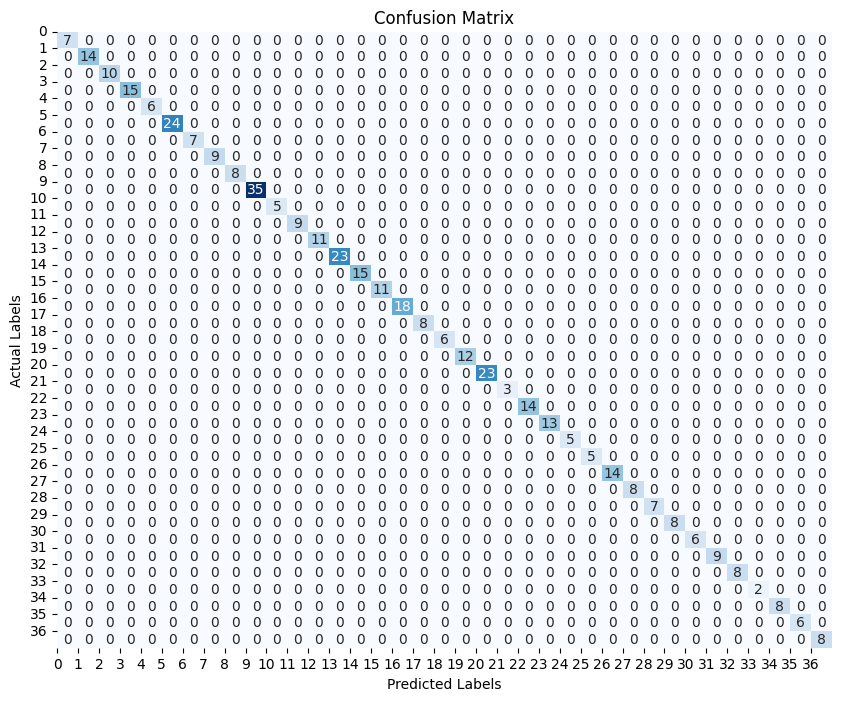

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming history_conv is your history object returned by model.fit()
# and conv_model is your trained model
predicted_labels = conv_model.predict(test_data)

# Convert one-hot encoded labels back to categorical labels
predicted_labels = np.argmax(predicted_labels, axis=1)
actual_labels = np.argmax(test_labels, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(np.unique(actual_labels))), labels=np.unique(actual_labels))
plt.yticks(ticks=np.arange(len(np.unique(actual_labels))), labels=np.unique(actual_labels))
plt.show()
